# SSBU VOD helper

Insert your URL and click _Run after_ (Ctrl + F10 OR Runtime -> Run after) to get your output.

Note: please use either Youtube OR Twitch at once.


## Dependencies

Imports dependencies.


In [1]:
import os
import os.path
import glob
from pathlib import Path
import subprocess

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from tensorflow.keras.models import load_model  # type: ignore

from utils import (
    predict_screen,
    video_to_frames,
    setup_dirs,
    apply_thresholding,
    group_frames,
    plot_1d_scatter,
    extract_vod_timestamps,
    frames_to_games,
    games_to_sets,
)

%reload_ext autoreload
%autoreload 2

2024-05-05 15:45:17.887222: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 15:45:17.925022: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 15:45:17.925064: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 15:45:17.925105: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 15:45:17.932660: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 15:45:17.933374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
# load model from directory
model = load_model("./model")

# source url/directory (only use youtube or twitch at one time)
youtube_url = ""
twitch_url = "https://www.twitch.tv/videos/2131834020"

### Download from YouTube


In [ ]:
try:
    import pytube
except ModuleNotFoundError:
    raise ModuleNotFoundError("Module pytube not found: install it and try again.")

if youtube_url:
    yt = pytube.YouTube(youtube_url.replace("watch?v=", ""))
    yt = (
        yt.streams.filter(progressive=True, file_extension="mp4")
        .order_by("resolution")
        .desc()
        .first()
    )

    if not os.path.exists("."):
        os.makedirs(".")

    if yt:
        yt.download(".")

### Download from Twitch


In [ ]:
import importlib
import importlib.util

if twitch_url:
    try:
        if importlib.util.find_spec("twitchdl"):
            subprocess.run(
                ["twitch-dl", "download", "-q", "160p", "-f", "mp4", twitch_url]
            )

    except ModuleNotFoundError:
        raise ModuleNotFoundError(
            "Module twitchdl not found: install it and try again."
        )

## Directories handling

Creates snapshots folder and video-specific subfolders starting from the last added (downloaded) file.


In [141]:
if twitch_url or youtube_url:
    # orders files by last added in order to grab last .mp4 file
    files = list(filter(os.path.isfile, glob.glob("*")))
    files.sort(key=lambda x: ".mp4" in x and os.path.getmtime(x))

    # handle situation in which no file is present
    if not files:
        raise Exception("An error has occurred: no video files in directory.")

    # get latest added file and set directory name
    input_file = files[-1]
    dir_name = input_file.replace(".mp4", "")
    vod_name = input_file[:21]

In [144]:
input_file = Path(input_file)
dataframes_dir, timestamps_dir, snapshots_dir = setup_dirs(vod_name)

Root data directory already exists, skipping.
Data directories already exist for 2024-04-28_2131834020


## Video to frames conversion

Uses `ffmpeg-python` to convert a video file to a succession of frames from the same video, grabbing one frame each second and resizing it to 426x240. **This process will take a lot of time** depending on the length of the video, so sit tight.


In [14]:
if not len(glob.glob(f"{snapshots_dir}/**")) > 0:
    print(f"Processing: {input_file}")
    video_to_frames(input_file, snapshots_dir)
else:
    print(f"Snapshots already exist for {input_file}; skipping.")

Processing: 2024-04-28_2131834020_smashbrositalia_ultimate_souls_iv_la_tomba_dei_giganti_ft_forze_107_dani_and_more.mp4


## Frames prediction


In [15]:
labels = {0: "gameplay", 1: "junk"}

snapshots = glob.glob(f"{snapshots_dir}/**")

predictions = [predict_screen(model, snap, labels) for snap in snapshots]

1/1 [==============================] - 0s 24ms/step


In [16]:
df = frames_to_games(predictions)
df.to_csv(f"{dataframes_dir}/predictions.csv", index=False)

df

,frame,label,confidence,timestamp,group,duration
0,0.jpg,junk,0.998939,1970-01-01 00:00:00,1,3
1,1.jpg,junk,0.986182,1970-01-01 00:00:01,1,3
2,2.jpg,junk,0.991371,1970-01-01 00:00:02,1,3
3,3.jpg,gameplay,0.999177,1970-01-01 00:00:03,2,249
4,4.jpg,gameplay,0.999995,1970-01-01 00:00:04,2,249
...,...,...,...,...,...,...
22466,22466.jpg,junk,0.983990,1970-01-01 06:14:26,455,28
22467,22467.jpg,junk,0.989513,1970-01-01 06:14:27,455,28
22468,22468.jpg,junk,0.981334,1970-01-01 06:14:28,455,28
22469,22469.jpg,junk,0.992440,1970-01-01 06:14:29,455,28


## Handling predictions


In [145]:
df = pd.read_csv(f"{dataframes_dir}/predictions.csv")
df

,frame,label,confidence,timestamp,group,duration
0,0.jpg,junk,0.998938,1970-01-01 00:00:00,1,3
1,1.jpg,junk,0.986182,1970-01-01 00:00:01,1,3
2,2.jpg,junk,0.991371,1970-01-01 00:00:02,1,3
3,3.jpg,gameplay,0.999177,1970-01-01 00:00:03,2,249
4,4.jpg,gameplay,0.999995,1970-01-01 00:00:04,2,249
...,...,...,...,...,...,...
22466,22466.jpg,junk,0.983990,1970-01-01 06:14:26,455,28
22467,22467.jpg,junk,0.989513,1970-01-01 06:14:27,455,28
22468,22468.jpg,junk,0.981334,1970-01-01 06:14:28,455,28
22469,22469.jpg,junk,0.992440,1970-01-01 06:14:29,455,28


In [146]:
# save number of rows to measure thresholding later
old_n_rows = df.shape[0]

# remove every row with duration less than the threshold
df = apply_thresholding(df, "duration", threshold=15)

print(f"{old_n_rows - df.shape[0]} rows removed by thresholding.")

df

623 rows removed by thresholding.


,frame,label,confidence,timestamp,group,duration
3,3.jpg,gameplay,0.999177,1970-01-01 00:00:03,1,249
4,4.jpg,gameplay,0.999995,1970-01-01 00:00:04,1,249
5,5.jpg,gameplay,0.999989,1970-01-01 00:00:05,1,249
6,6.jpg,gameplay,0.999985,1970-01-01 00:00:06,1,249
7,7.jpg,gameplay,0.999968,1970-01-01 00:00:07,1,249
...,...,...,...,...,...,...
22466,22466.jpg,junk,0.983990,1970-01-01 06:14:26,150,28
22467,22467.jpg,junk,0.989513,1970-01-01 06:14:27,150,28
22468,22468.jpg,junk,0.981334,1970-01-01 06:14:28,150,28
22469,22469.jpg,junk,0.992440,1970-01-01 06:14:29,150,28


In [147]:
group_df = group_frames(df)
group_df.to_csv(f"{dataframes_dir}/games.csv")

group_df

,frame,label,confidence,timestamp,duration,end_ts
group,,,,,,
1,3.jpg,gameplay,0.999177,1970-01-01 00:00:03,249,1970-01-01 00:04:11
2,252.jpg,junk,0.998230,1970-01-01 00:04:12,25,1970-01-01 00:04:36
3,277.jpg,gameplay,0.999895,1970-01-01 00:04:37,206,1970-01-01 00:08:02
4,483.jpg,junk,0.998874,1970-01-01 00:08:03,33,1970-01-01 00:08:35
5,516.jpg,gameplay,0.737267,1970-01-01 00:08:36,258,1970-01-01 00:12:53
...,...,...,...,...,...,...
146,22013.jpg,junk,0.918102,1970-01-01 06:06:53,24,1970-01-01 06:07:16
147,22037.jpg,gameplay,0.999990,1970-01-01 06:07:17,154,1970-01-01 06:09:50
148,22194.jpg,junk,0.903252,1970-01-01 06:09:54,29,1970-01-01 06:10:22


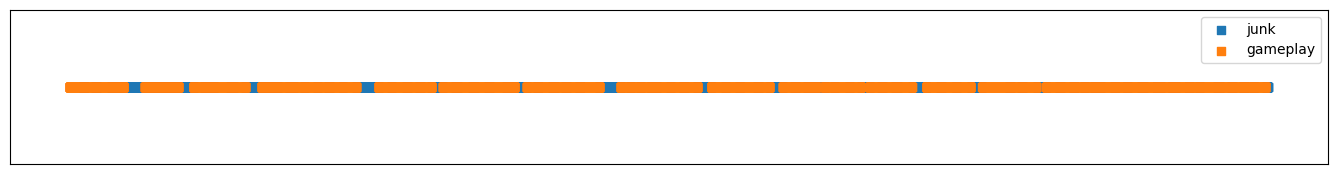

In [148]:
fig = plt.figure(figsize=(17, 2))

date_formatter = mdates.DateFormatter("%H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_formatter)

# plot_1d_scatter(df[df["label"] == "junk"], "timestamp", "junk")
# plot_1d_scatter(df[df["label"] == "gameplay"], "timestamp", "gameplay")

if "level_0" not in df.columns:
    df = df.reset_index()
plot_1d_scatter(df[df["label"] == "junk"], "index", "junk")
plot_1d_scatter(df[df["label"] == "gameplay"], "index", "gameplay")

plt.yticks([])
plt.xticks([])

plt.legend()

## Clustering


In [149]:
games_df = pd.read_csv(
    f"{dataframes_dir}/games.csv", parse_dates=["timestamp", "end_ts"]
)
games_df

,group,frame,label,confidence,timestamp,duration,end_ts
0,1,3.jpg,gameplay,0.999177,1970-01-01 00:00:03,249,1970-01-01 00:04:11
1,2,252.jpg,junk,0.998230,1970-01-01 00:04:12,25,1970-01-01 00:04:36
2,3,277.jpg,gameplay,0.999895,1970-01-01 00:04:37,206,1970-01-01 00:08:02
3,4,483.jpg,junk,0.998874,1970-01-01 00:08:03,33,1970-01-01 00:08:35
4,5,516.jpg,gameplay,0.737267,1970-01-01 00:08:36,258,1970-01-01 00:12:53
...,...,...,...,...,...,...,...
145,146,22013.jpg,junk,0.918102,1970-01-01 06:06:53,24,1970-01-01 06:07:16
146,147,22037.jpg,gameplay,0.999990,1970-01-01 06:07:17,154,1970-01-01 06:09:50
147,148,22194.jpg,junk,0.903252,1970-01-01 06:09:54,29,1970-01-01 06:10:22
148,149,22226.jpg,gameplay,0.999730,1970-01-01 06:10:26,198,1970-01-01 06:13:43


Timestamps file already exists:

title | round - player1 (char1) vs player2 (char2) -- 00:00:00 - 00:16:55 -- 1 
title | round - player1 (char1) vs player2 (char2) -- 00:23:28 - 00:33:59 -- 2 
title | round - player1 (char1) vs player2 (char2) -- 00:38:39 - 00:50:16 -- 3 
title | round - player1 (char1) vs player2 (char2) -- 00:51:35 - 00:54:55 -- 4 
title | round - player1 (char1) vs player2 (char2) -- 00:59:59 - 01:29:34 -- 5 
title | round - player1 (char1) vs player2 (char2) -- 01:36:30 - 01:53:09 -- 6 
title | round - player1 (char1) vs player2 (char2) -- 01:56:39 - 02:19:07 -- 7 
title | round - player1 (char1) vs player2 (char2) -- 02:22:53 - 02:45:37 -- 8 
title | round - player1 (char1) vs player2 (char2) -- 02:52:14 - 03:01:40 -- 9 
title | round - player1 (char1) vs player2 (char2) -- 03:03:26 - 03:16:16 -- 10 
title | round - player1 (char1) vs player2 (char2) -- 03:20:33 - 03:38:46 -- 11 
title | round - player1 (char1) vs player2 (char2) -- 03:42:56 - 04:07:21 -- 12 
titl

/home/impasse/Code/Projects/VOD-Assistant/utils.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "cluster"] = labels


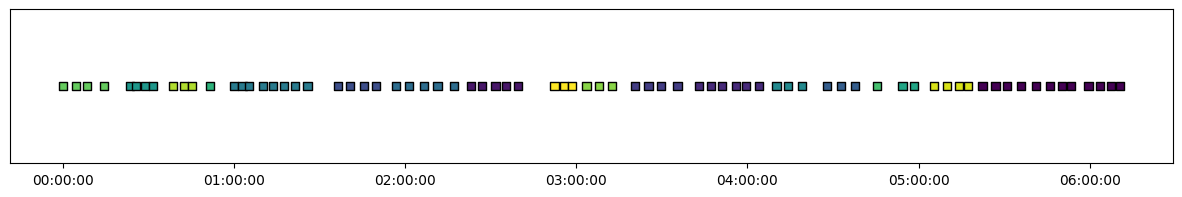

In [172]:
n_clusters = 18
sets_df = games_to_sets(games_df, n_clusters=n_clusters)

# plot clustering
clusters_labels = [sets_df[labels == i] for i in range(n_clusters)]

fig = plt.figure(figsize=(15, 2))

date_formatter = mdates.DateFormatter("%H:%M:%S")
plt.gca().xaxis.set_major_formatter(date_formatter)

plt.yticks([])

plot_1d_scatter(sets_df, "timestamp", c="cluster", edgecolors="black")

extract_vod_timestamps(
    sets_df,
    f"{timestamps_dir}/{vod_name}.md",
    buffer=7,
    override=False,
)